In [13]:
import pandas as pd # Python library for data analysis and data frame
import numpy as np # Numerical Python library for linear algebra and computations

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8); # setting the figuresize 

from datetime import datetime, date #Library to deal with datetime columns

# time series analysis libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# time series forecasting libraries
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

# Neural network required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# model evaluation libraries
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#for saving trained model
import pickle

import warnings
warnings.filterwarnings("ignore") # To prevent kernel from showing any warning

In [14]:
df = pd.read_csv("DayForecast.csv")

In [15]:
df

Date  Quantity
0    2022-01-01        50
1    2022-01-02        65
2    2022-01-03        92
3    2022-01-04        86
4    2022-01-05        72
..          ...       ...
360  2022-12-27        83
361  2022-12-28        96
362  2022-12-29       102
363  2022-12-30        50
364  2022-12-31        74

[365 rows x 2 columns]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      365 non-null    object
 1   Quantity  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [17]:
df['Date'] = pd.to_datetime(df['Date'])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      365 non-null    datetime64[ns]
 1   Quantity  365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


In [19]:
df.set_index(['Date'], inplace=True) # changing index to datetime

In [20]:
df.head()

Quantity
Date                
2022-01-01        50
2022-01-02        65
2022-01-03        92
2022-01-04        86
2022-01-05        72

In [21]:
df.index.min(), df.index.max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2022-12-31 00:00:00'))

In [22]:
# checking if data is continues
if (df.index.max() - df.index.min() == 214): 
    print('Data Is Continuous')

((array([-2.89476187, -2.60416026, -2.44008156, -2.32339534, -2.23174377,
         -2.15571559, -2.09042256, -2.032987  , -1.98156619, -1.93490632,
         -1.89211417, -1.85253003, -1.81565229, -1.78109027, -1.74853354,
         -1.71773117, -1.68847732, -1.66060095, -1.63395835, -1.60842754,
         -1.58390407, -1.56029777, -1.53753027, -1.51553298, -1.4942455 ,
         -1.4736144 , -1.45359213, -1.4341362 , -1.41520849, -1.39677463,
         -1.37880355, -1.36126705, -1.34413948, -1.32739738, -1.3110193 ,
         -1.29498553, -1.27927793, -1.26387978, -1.24877561, -1.23395108,
         -1.21939287, -1.20508862, -1.19102679, -1.1771966 , -1.16358798,
         -1.15019151, -1.13699834, -1.12400016, -1.11118916, -1.09855798,
         -1.08609968, -1.07380771, -1.06167589, -1.04969834, -1.03786952,
         -1.02618416, -1.01463728, -1.00322411, -0.99194016, -0.98078111,
         -0.96974287, -0.95882155, -0.9480134 , -0.93731488, -0.92672259,
         -0.91623326, -0.90584378, -0.

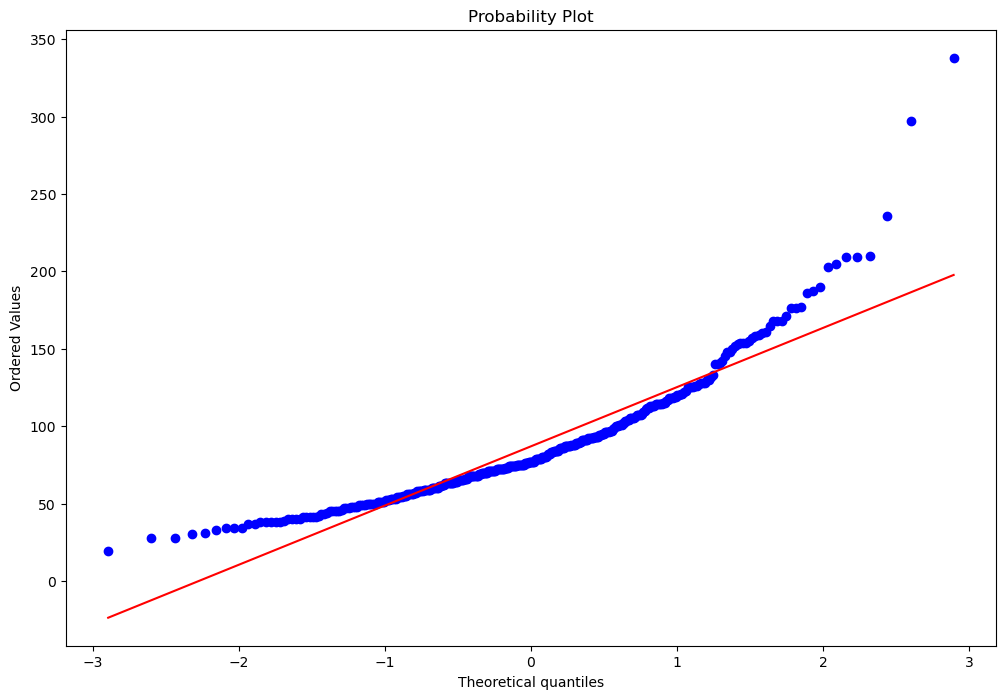

In [38]:
# Checking Whether data is normally distributed
import scipy. stats as stats
import pylab
stats.probplot(df. Quantity, dist="norm", plot=pylab)

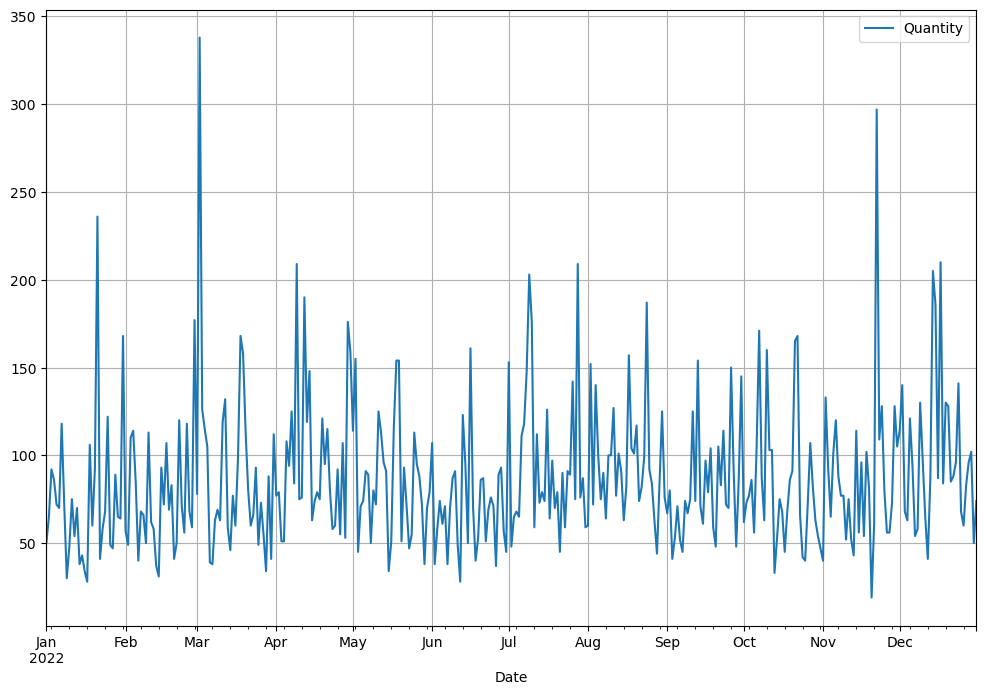

In [24]:
df.plot(grid=True);

Data has some seasonality, and trend is present and maybe cyclicity too

In [25]:
#split the data into train and test
size = int(len(df)*0.70)
#splitting the first 70% data zto train and the rest to test

In [26]:
train_df = df[:size]
train_df.tail()

Quantity
Date                
2022-09-08        74
2022-09-09        67
2022-09-10        75
2022-09-11       125
2022-09-12        74

In [27]:
test_df = df[size:]
test_df.head()

Quantity
Date                
2022-09-13       154
2022-09-14        71
2022-09-15        61
2022-09-16        97
2022-09-17        79

In [29]:
train_df. shape


(255, 1)

In [30]:
test_df. shape

(110, 1)

Time Series Decomposition:
A time series is usually composed of the following components:

1) Trend : This component usually is increasing, decreasing, or constant.
2) Seasonality : This is the periodic behavior of the time series that occurs within a year.
3) Residual : This is what remains of the time series after the trend and seasonality are removed.

The basic approach to seasonal decomposition splits the time series into above components.

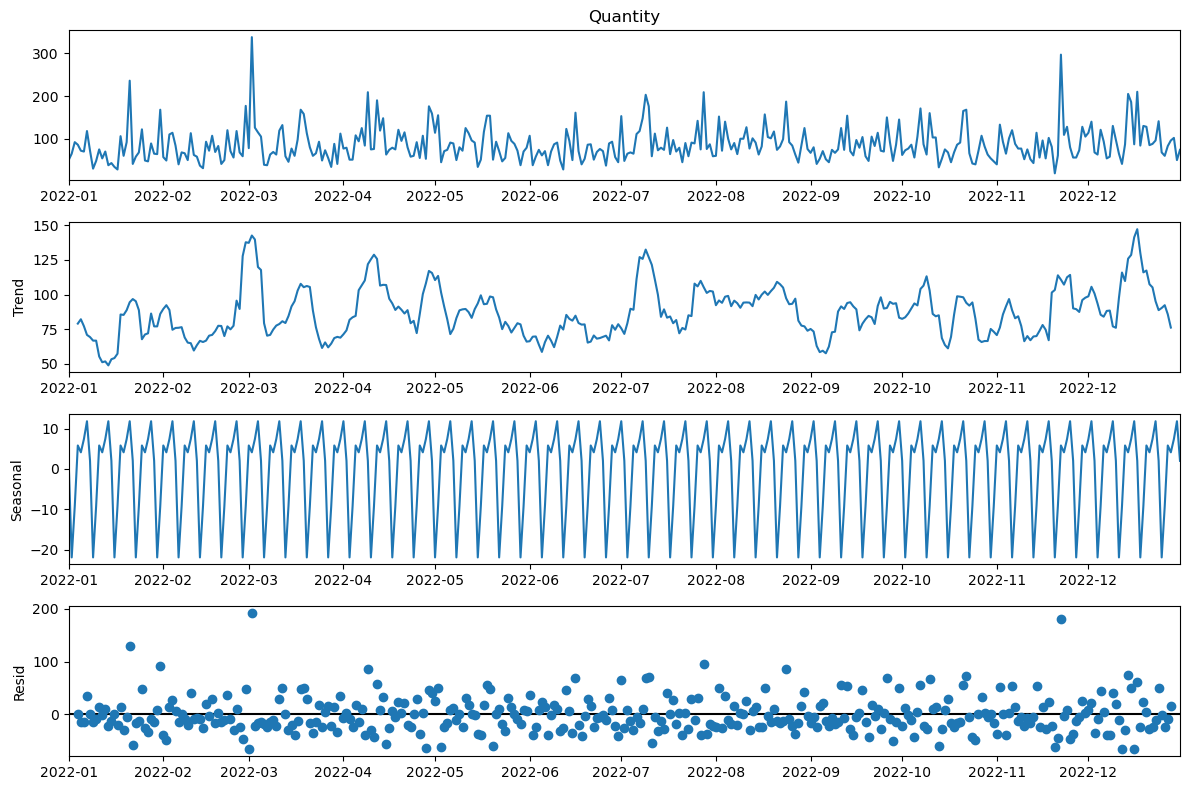

In [31]:
decompose_add = seasonal_decompose(df['Quantity'])
decompose_add.plot();

Stationary Time Series :
A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict

Sign of obvious trends, seasonality, or other systematic structures in the series are indicators of a non-stationary series. A more accurate method would be to use a statistical test, such as the Dickey-Fuller test.

ADFuller Test:
If Test statistic < Critical Value and p-value < 0.05 – then series is stationary

In [32]:
# functon for adf test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print ('----------------------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adftest[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print (adf_output)
    
# calling adf function and passing series
adf_test(df.values)

Results of Dickey-Fuller Test:
----------------------------------------------
Test Statistic                -1.643027e+01
p-value                        2.482293e-29
#Lags Used                     0.000000e+00
Number of Observations Used    3.640000e+02
Critical Value (1%)           -3.448443e+00
Critical Value (5%)           -2.869513e+00
Critical Value (10%)          -2.571018e+00
dtype: float64


Observation 👀
The p-value obtained is less than significance level of 0.05 and the ADF statistic is less than any of the critical values. Hence the series is stationary

Autocorrelation and Partial Autocorrelation Function:
Autocorrelation and partial autocorrelation are plots that graphically summarize the impact of observations at prior timesteps on the observations we are trying to predict.

ACF plot gives the q value and PACF gives the p value
Look for tail of pattern in either ACF or PACF. If tail is crossing the blue region then it will give us potential p and q values.

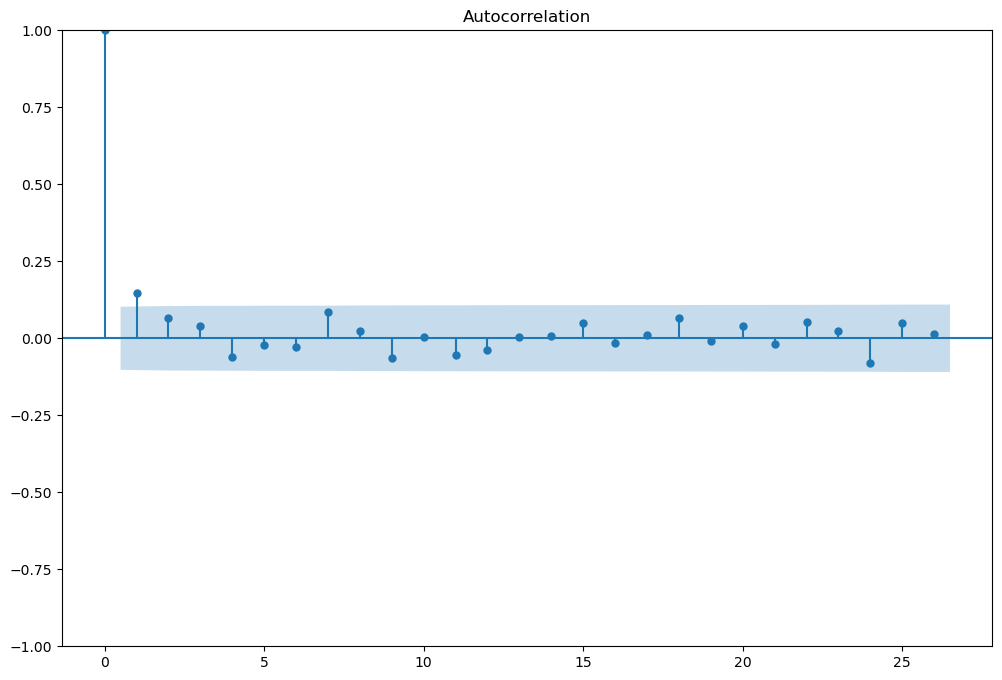

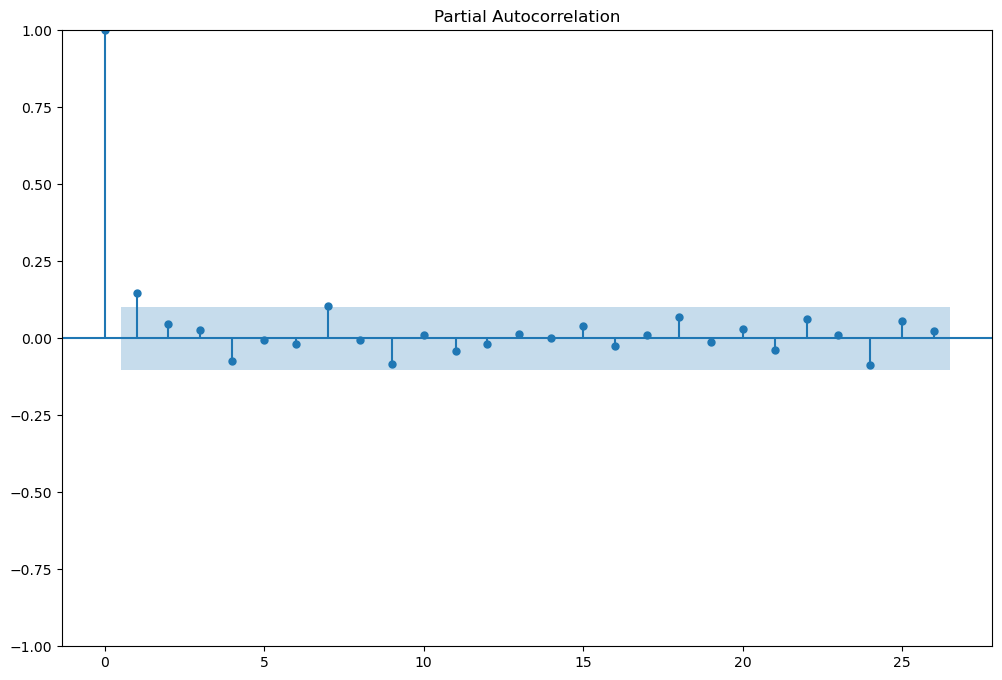

In [39]:
# if the series is not stationary then make sure to pass differenced series instead of original series
plot_acf(df);
plot_pacf(df);

Observation 👀
1.From ACF plot we can see that q values can be 1, 7 & 24
2.From PACF plot we can see that p values can be 1,7, & 24

Exponential Smoothing:
Exponential smoothing is a time series forecasting method for univariate data. There are three main types of exponential smoothing time series forecasting methods. A simple method that assumes no systematic structure, an extension that explicitly handles trends, and the most advanced approach that add support for seasonality.

Single Exponential Smoothing

Single Exponential Smoothing
Single Exponential Smoothing, SES for short, also called Simple Exponential Smoothing, is a time series forecasting method for univariate data without a trend or seasonality.

In [40]:
single_exp = SimpleExpSmoothing(train_df).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(110)

<AxesSubplot: xlabel='Date'>

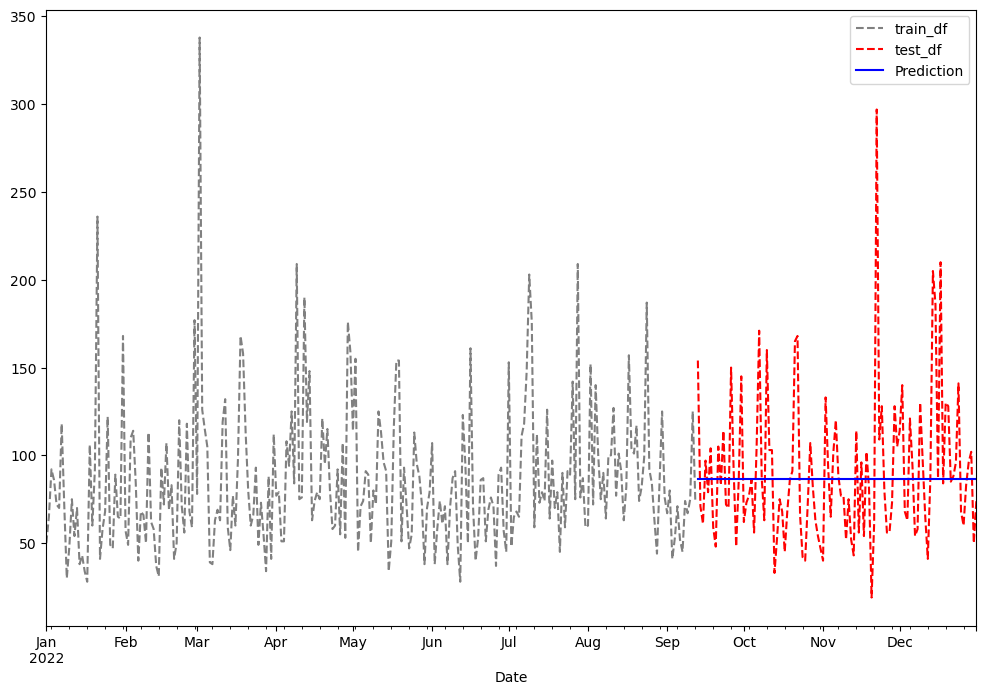

In [41]:
train_df['Quantity'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Quantity'].plot(style='--', color='r', legend=True, label='test_df')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [42]:
print('Train RMSE:',mean_squared_error(train_df, single_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, single_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, single_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, single_exp_test_pred))

Train RMSE: 40.25386901569328
Test RMSE: 41.89556634706332
Train MAPE: 0.4043407239922989
Test MAPE: 0.3750144932107129


Double Exponential Smoothing
Double Exponential Smoothing is an extension to Exponential Smoothing that explicitly adds support for trends in the univariate time series

In [43]:
double_exp = ExponentialSmoothing(train_df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(110)

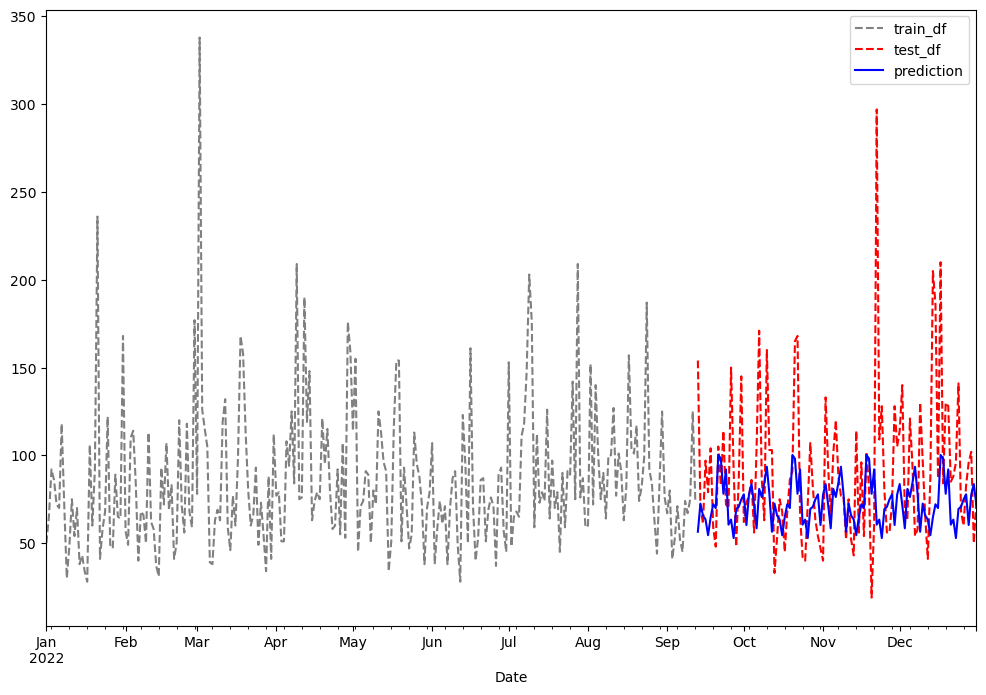

In [44]:
train_df['Quantity'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Quantity'].plot(style='--', color='r', legend=True, label='test_df')
double_exp_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [45]:
print('Train RMSE:',mean_squared_error(train_df, double_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, double_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, double_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, double_exp_test_pred))

Train RMSE: 40.17180528909413
Test RMSE: 46.05125619566321
Train MAPE: 0.38413112857364784
Test MAPE: 0.34293376340774706


Triple Exponential Smoothing
Triple Exponential Smoothing is an extension of Exponential Smoothing that explicitly adds support for seasonality to the univariate time series. Also known as Holt-Winters Exponential Smoothing.

In [46]:
hw_model = ExponentialSmoothing(train_df['Quantity'],
                          trend    ='add',
                          initialization_method='heuristic',
                          seasonal = "add", 
                          seasonal_periods=28, 
                          damped_trend=True).fit()
hw_train_pred =  hw_model.fittedvalues
hw_test_pred =  hw_model.forecast(110)

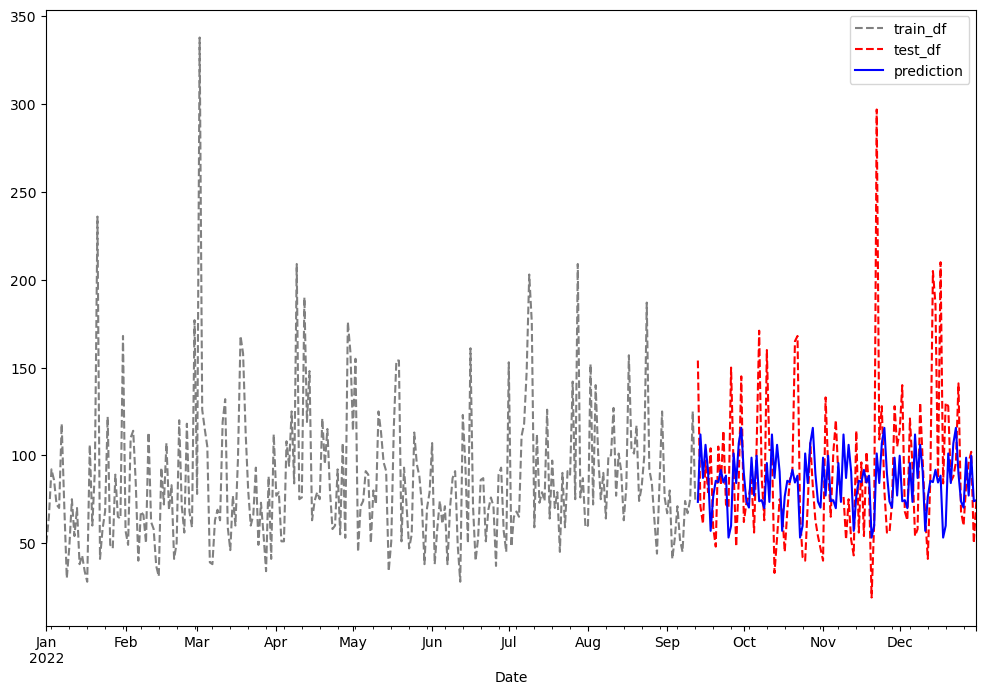

In [47]:
train_df['Quantity'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Quantity'].plot(style='--', color='r', legend=True, label='test_df')
hw_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [48]:
print('Train RMSE:',mean_squared_error(train_df, hw_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, hw_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, hw_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, hw_test_pred))

Train RMSE: 37.03975421193037
Test RMSE: 42.078092077913176
Train MAPE: 0.3434638317226242
Test MAPE: 0.35387608109146784


ARIMA
A popular and widely used statistical method for time series forecasting is the ARIMA model. ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. The parameters of the ARIMA model are defined as follows:

p : The number of lag observations included in the model, also called the lag order.
d : The number of times that the raw observations are differenced, also called the degree of differencing.
q : The size of the moving average window, also called the order of moving average.

In [49]:
# we got the p,d,q value from time series analysis
ar = ARIMA(train_df, order=(7,1,7)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(110)

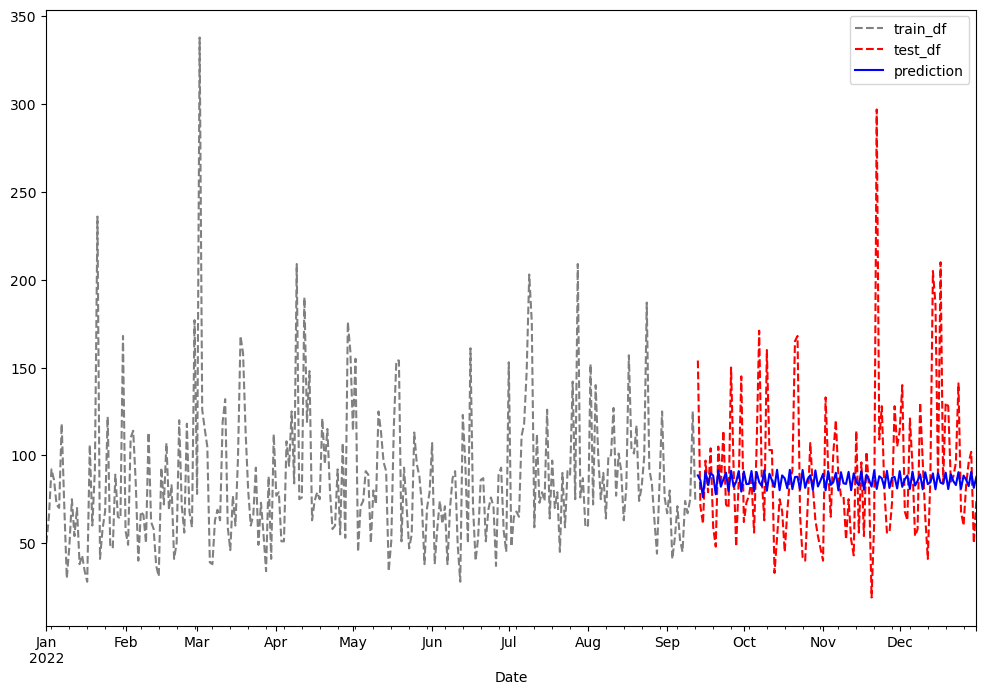

In [50]:
train_df['Quantity'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Quantity'].plot(style='--', color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [51]:
print('Train RMSE:',mean_squared_error(train_df, ar_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, ar_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, ar_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, ar_test_pred))

Train RMSE: 38.60524118469059
Test RMSE: 42.07085466231088
Train MAPE: 0.3562849361669452
Test MAPE: 0.36631051346386234


Grid Search p,d,q Values
From acf and pacf we got different potenstial p,q values. Lets use grid search to find the best pair out of them

In [52]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(arima_order):
    # prepare training dataset
    train_df = df[:size]
    test_df = df[size:]
    # make predictions
    model = ARIMA(train_df, order=arima_order).fit()
    model_pred = model.forecast(110)
    rmse = (mean_squared_error(test_df, model_pred)**0.5)
    return rmse

In [54]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for q in q_values:
				order = (p,1,q)
				try:
					rmse = evaluate_arima_model(order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [55]:
# evaluate parameters
p_values = [1,7,24]
q_values = [1,7,24]

evaluate_models(df['Quantity'].values, p_values, q_values)

Best ARIMA(1, 1, 7) RMSE=41.832


In [56]:
arima = ARIMA(train_df['Quantity'], order=(7,1,7)).fit()
arima_train_pred = arima.predict()
arima_test_pred = arima.forecast(110)

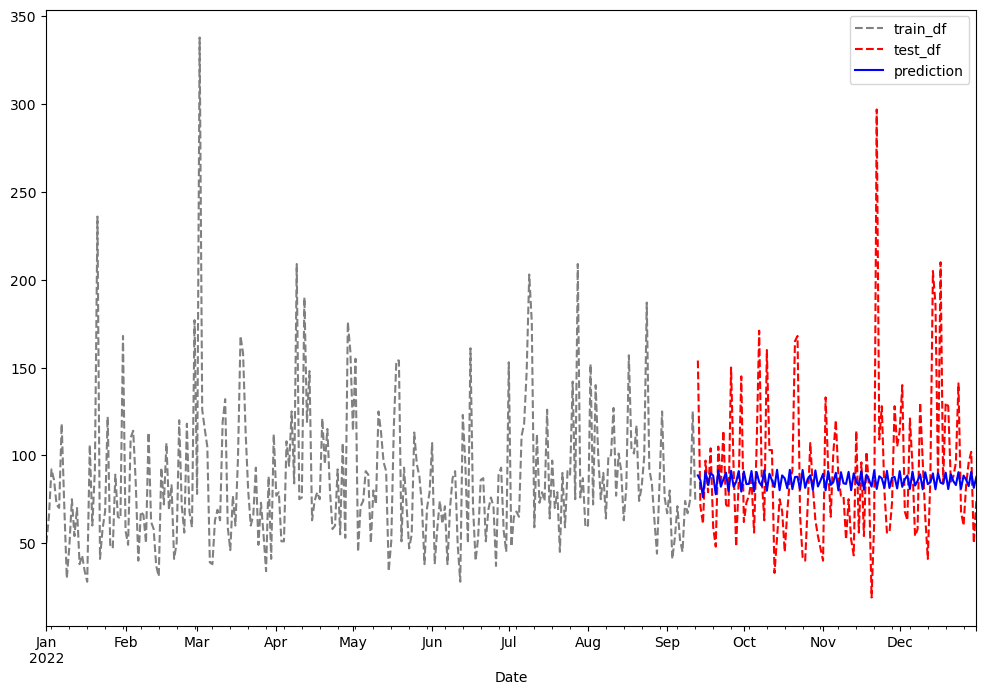

In [57]:
train_df['Quantity'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Quantity'].plot(style='--', color='r', legend=True, label='test_df')
arima_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [58]:
print('Train RMSE:',mean_squared_error(train_df, arima_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, arima_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, arima_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, arima_test_pred))

Train RMSE: 38.60524118469059
Test RMSE: 42.07085466231088
Train MAPE: 0.3562849361669452
Test MAPE: 0.36631051346386234


Auto ARIMA
Although ARIMA is a very powerful model for forecasting time series data, the data preparation and parameter tuning processes end up being really time consuming. Before implementing ARIMA, you need to make the series stationary, and determine the values of p and q using the plots we discussed above. Auto ARIMA makes this task really simple for us as it eliminates many steps

In [59]:
auto_arima(df['Quantity'], m=30, max_order= None, max_p=16, max_q=16, max_d=1,max_P=16, max_Q=16, max_D=2, maxiter=50, alpha=0.05, n_jobs=-1,information_criterion='aic', out_of_sample_size=30).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1867.122
Date:                Fri, 31 Mar 2023   AIC                           3740.245
Time:                        22:16:50   BIC                           3751.944
Sample:                             0   HQIC                          3744.894
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     74.1818      5.956     12.456      0.000      62.509      85.855
ar.L1          0.1458      0.057      2.544      0.011       0.033       0.258
sigma2      1598.5161     76.159     20.989      0.000    1449.247    1747.785
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               820.27
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             1.87
Prob(H) (two-sided):                  0.21   Kurtosis:                         9.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
# pass the order and seasonal order values we got from auto arima
sarima = SARIMAX(train_df['Quantity'], order=(0,1,0), seasonal_order=(1,0,0,30)).fit()
sarima_train_pred = sarima.predict()
sarima_test_pred = sarima.forecast(110)

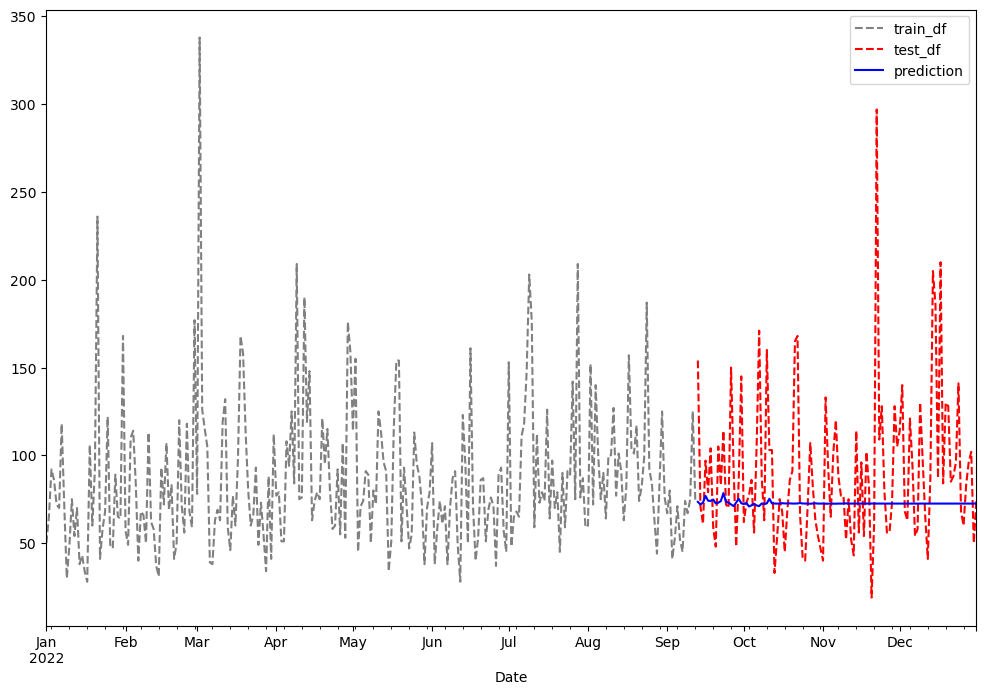

In [64]:
train_df['Quantity'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Quantity'].plot(style='--', color='r', legend=True, label='test_df')
sarima_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [65]:
print('Train RMSE:',mean_squared_error(train_df, sarima_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, sarima_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, sarima_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, sarima_test_pred))

Train RMSE: 52.5521934326404
Test RMSE: 45.312079812357176
Train MAPE: 0.4817234210872517
Test MAPE: 0.3275289724651404


Prophet

Prophet
The Prophet library is an open-source library designed for making forecasts for univariate time series datasets. It is easy to use and designed to automatically find a good set of hyperparameters for the model in an effort to make skillful forecasts for data with trends and seasonal structure by default.

The DataFrame must have a specific format. The first column must have the name ‘ds‘ and contain the date-times. The second column must have the name ‘y‘ and contain the observations.

In [66]:
# converting the original dataframe into required format by prophet
prophet_df = df.copy()
prophet_df.reset_index(inplace=True)
prophet_df.columns=['ds','y']
prophet_df.head()

ds   y
0 2022-01-01  50
1 2022-01-02  65
2 2022-01-03  92
3 2022-01-04  86
4 2022-01-05  72

In [67]:
# train test split data
prophet_train_df = prophet_df.iloc[:-110]
prophet_test_df = prophet_df.iloc[-110:]

In [68]:
prophet_model = Prophet()
prophet_model.fit(prophet_train_df) #fit training data to model

22:41:37 - cmdstanpy - INFO - Chain [1] start processing
22:41:37 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
future = prophet_model.make_future_dataframe(periods=23, freq='YS')
prophet_predictions = prophet_model.predict(future)

In [70]:
prophet_predictions.tail()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
273 2041-01-01  329.047261  261.955415  404.201228   280.960110   379.946087   
274 2042-01-01  342.059111  275.209888  425.768520   290.977620   397.739962   
275 2043-01-01  355.070960  289.341590  444.820343   299.037125   414.964750   
276 2044-01-01  368.082810  299.572436  458.270409   308.087014   432.848437   
277 2045-01-01  381.130308  280.107139  443.325366   315.765460   450.852729   

     additive_terms  additive_terms_lower  additive_terms_upper     weekly  \
273        4.601283              4.601283              4.601283   4.601283   
274        4.416840              4.416840              4.416840   4.416840   
275       11.304211             11.304211             11.304211  11.304211   
276       10.094129             10.094129             10.094129  10.094129   
277      -21.249730            -21.249730            -21.249730 -21.249730   

     weekly_lower  weekly_upper  multiplicative_terms  \
273      4.601283      4.601283                   0.0   
274      4.416840      4.416840                   0.0   
275     11.304211     11.304211                   0.0   
276     10.094129     10.094129                   0.0   
277    -21.249730    -21.249730                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
273                         0.0                         0.0  333.648544  
274                         0.0                         0.0  346.475950  
275                         0.0                         0.0  366.375171  
276                         0.0                         0.0  378.176939  
277                         0.0                         0.0  359.880578

In [71]:
plot_plotly(prophet_model, prophet_predictions)

In [72]:
prophet_train_df['prophet_train_pred'] = prophet_predictions.iloc[:-110]['yhat']
prophet_test_df['prophet_test_pred'] = prophet_predictions.iloc[-110:]['yhat']

In [84]:
comparision_df = pd.DataFrame(data=[['Single exp smoothing', 41.89 , 0.37],
                           ['double exp smoothing', 46.05,  0.34],
                          ['Triple exp smoothing', 42.07, 0.34],
                          ['ARIMA(15,1,15)', 42.071, 0.36],
                          ['ARIMA(16,1,16)', 42.07, 0.36],
                          ['SARIMA(0,1,0)(1,0,0,30)', 45.31, 0.32]],columns=['Model','RMSE','MAPE'])

comparision_df.set_index('Model', inplace=True)

In [86]:
comparision_df.sort_values(by='MAPE')

RMSE  MAPE
Model                                
SARIMA(0,1,0)(1,0,0,30)  45.310  0.32
double exp smoothing     46.050  0.34
Triple exp smoothing     42.070  0.34
ARIMA(15,1,15)           42.071  0.36
ARIMA(16,1,16)           42.070  0.36
Single exp smoothing     41.890  0.37

In [87]:
double_exp = ExponentialSmoothing(df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()


In [91]:
double_exp_pred = double_exp.forecast(120)

In [95]:
double_exp_pred

2023-01-01     80.412620
2023-01-02    105.720458
2023-01-03    104.589304
2023-01-04     96.788857
2023-01-05    105.743948
                 ...    
2023-04-26     97.618287
2023-04-27     80.412620
2023-04-28    105.720458
2023-04-29    104.589304
2023-04-30     96.788857
Freq: D, Length: 120, dtype: float64

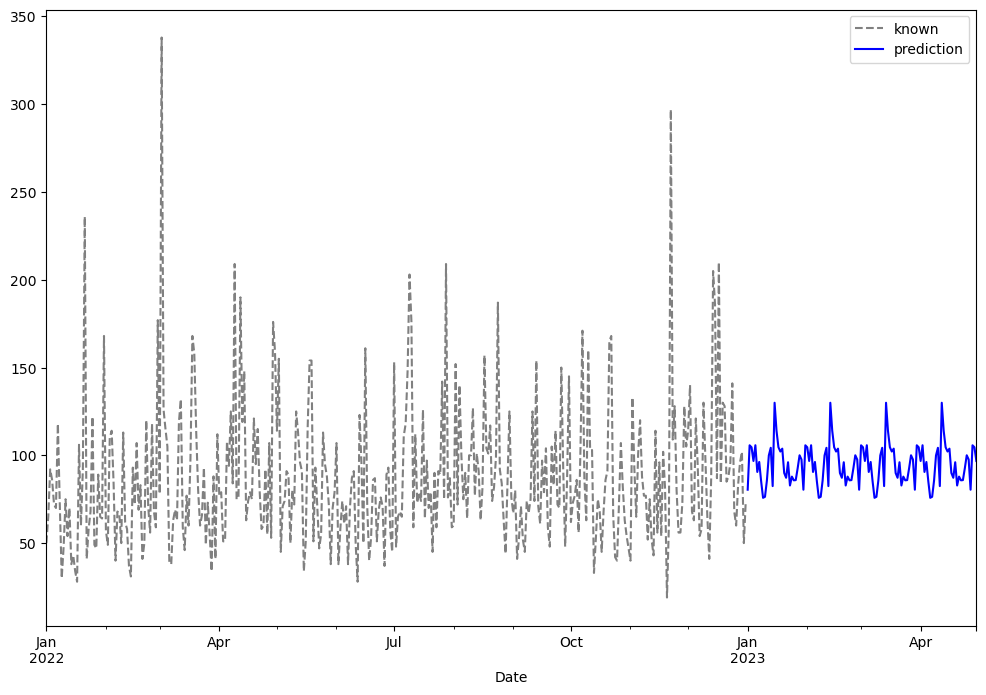

In [92]:
df['Quantity'].plot(style='--', color='gray', legend=True, label='known')
double_exp_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [94]:
pickle.dump(double_exp, open('forecast_model_doubleexp.pickle','wb'))